In [1]:
import h5py
from transformers import AutoModelForMaskedLM, AutoTokenizer
import sys
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
sys.path.append('/home/amber/multitask_RNA/data_generation')
import utils
import numpy as np

In [2]:
file = h5py.File("/home/amber/multitask_RNA/data/CAGI/CAGI_onehot.h5", "r")
alt = file['alt']
ref = file['ref']

## GPN claim zero shot learning with log p(alt)/p(ref)

Need to mask the center nuceltide of each seq and get the p value

In [3]:
import torch
import transformers
import gpn.mlm
model = AutoModelForMaskedLM.from_pretrained("/home/amber/multitask_RNA/model/GPN_finetune/checkpoint-2000000").to('cuda')
tokenizer = AutoTokenizer.from_pretrained("/home/amber/multitask_RNA/model/GPN_finetune/checkpoint-2000000")
model.eval();

In [4]:
N, L, A = alt.shape
mut_i = int(L/2-1)
cagi_llr=[]
for i in range(N):
    ref_a = np.argmax(ref[i][mut_i])+2
    alt_a = np.argmax(alt[i][mut_i])+2
    seq = utils.onehot_to_seq([ref[i]])
    token = tokenizer.batch_encode_plus(seq)['input_ids'][0]
    token[mut_i] = tokenizer.mask_token_id
    output = model(torch.tensor([token]).to('cuda')).logits.cpu().detach().numpy()
    llr = output[0][mut_i][alt_a] - output[0][mut_i][ref_a]
    cagi_llr.append(llr)


In [34]:
output = h5py.File('./cagi_gpn.h5', 'w')
output.create_dataset('llr', data=np.array(cagi_llr))

<HDF5 dataset "llr": shape (18442,), type "<f4">

## Visulization


In [1]:
import h5py
import pandas as pd
import numpy as np
from operator import itemgetter
import seaborn as sns
import matplotlib.pyplot as plt 
cagi_result = h5py.File('./cagi_gpn.h5', 'r')
llr = cagi_result['llr'][()]

In [2]:
cagi_df = pd.read_csv('../../data/CAGI/final_cagi_metadata.csv',
                      index_col=0).reset_index()
exp_list = cagi_df['8'].unique()

In [3]:
exp_list

array(['HBB', 'SORT1', 'TERT-GBM', 'PKLR', 'MYCrs6983267', 'IRF6', 'MSMB',
       'HBG1', 'TERT-HEK293T', 'F9', 'ZFAND3', 'HNF4A', 'IRF4', 'GP1BB',
       'LDLR'], dtype=object)

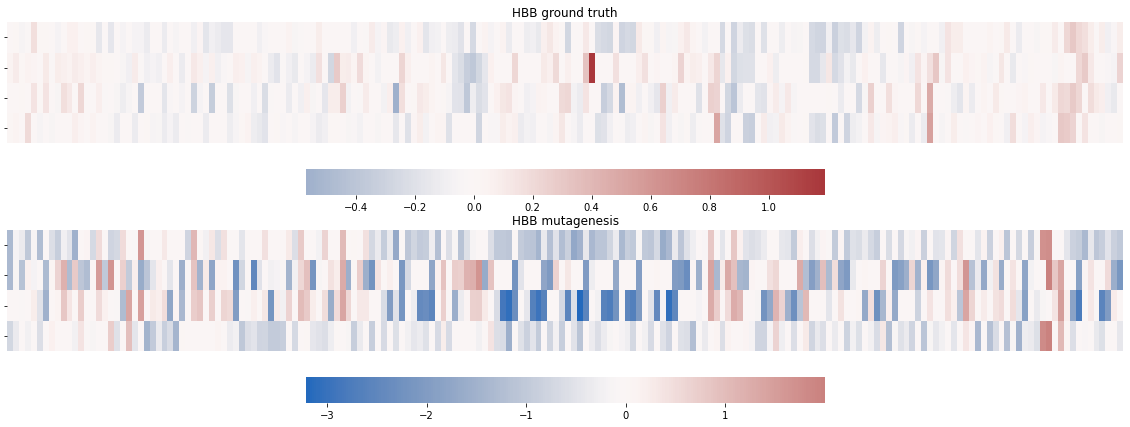

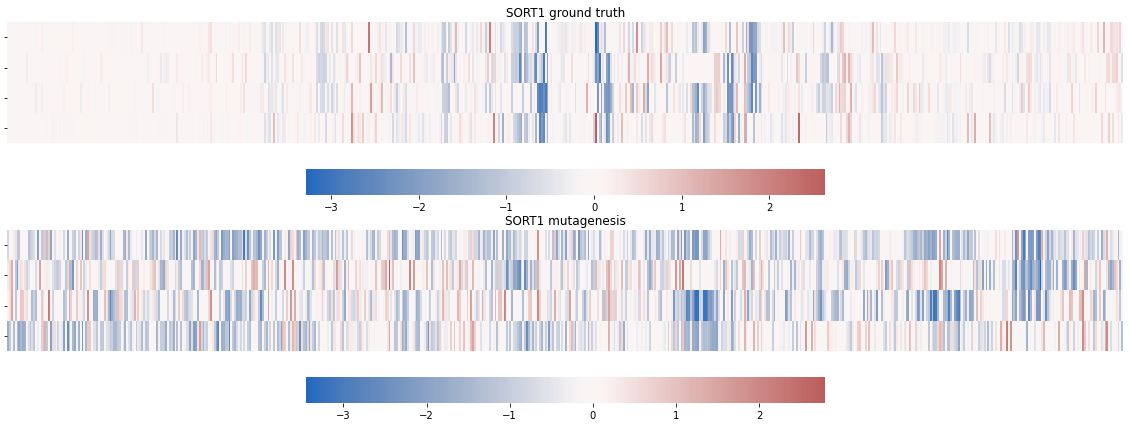

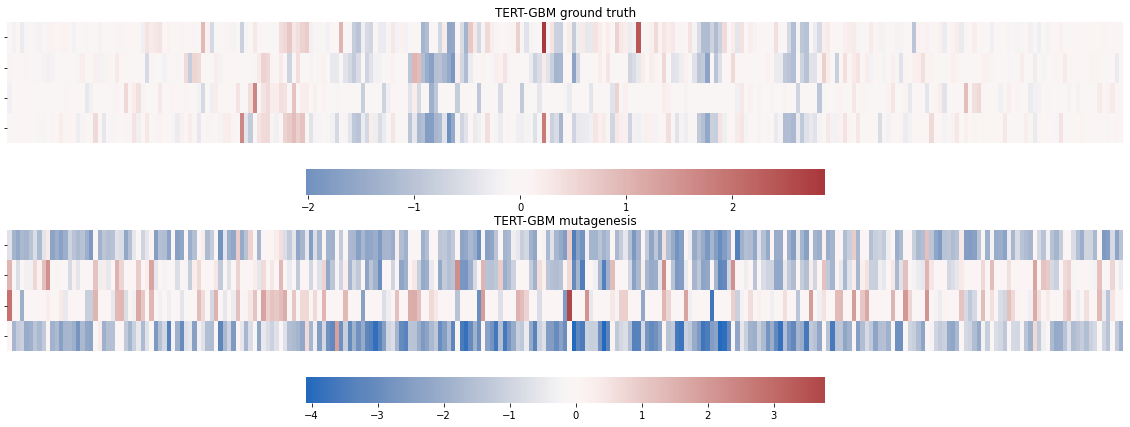

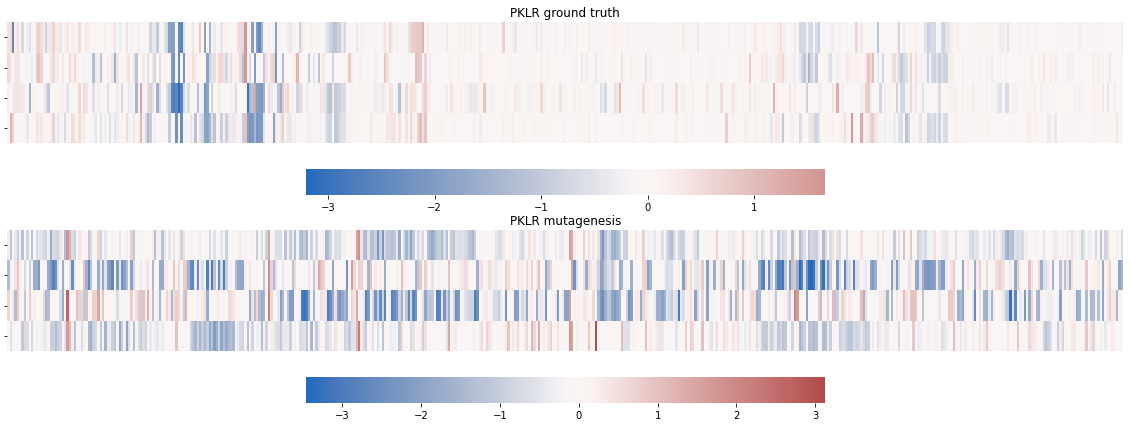

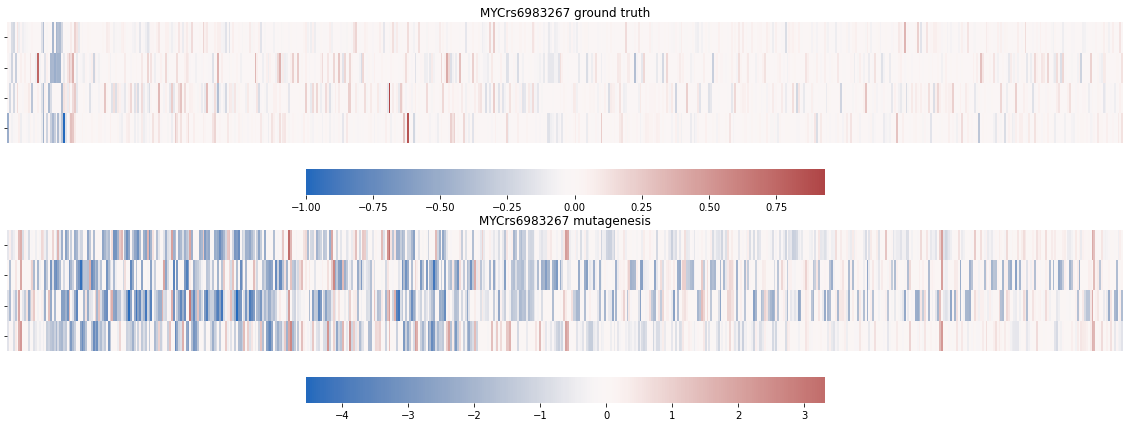

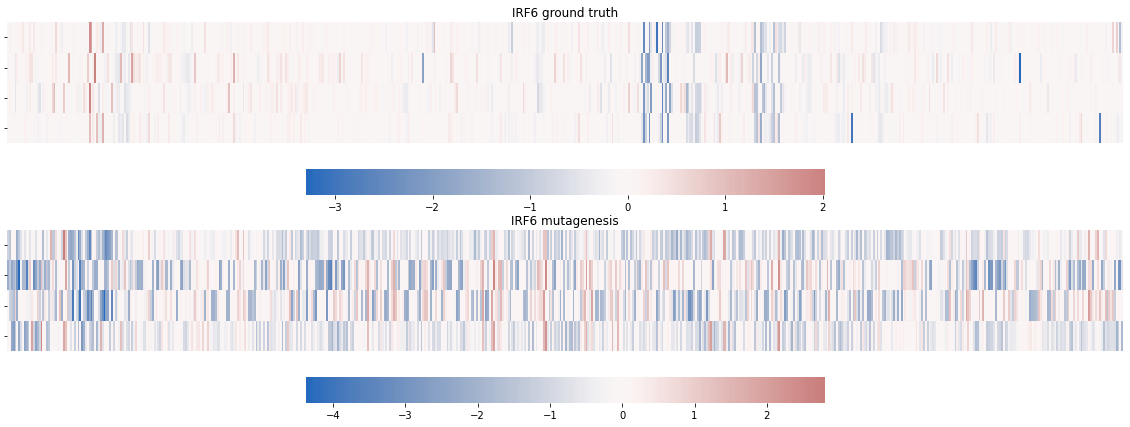

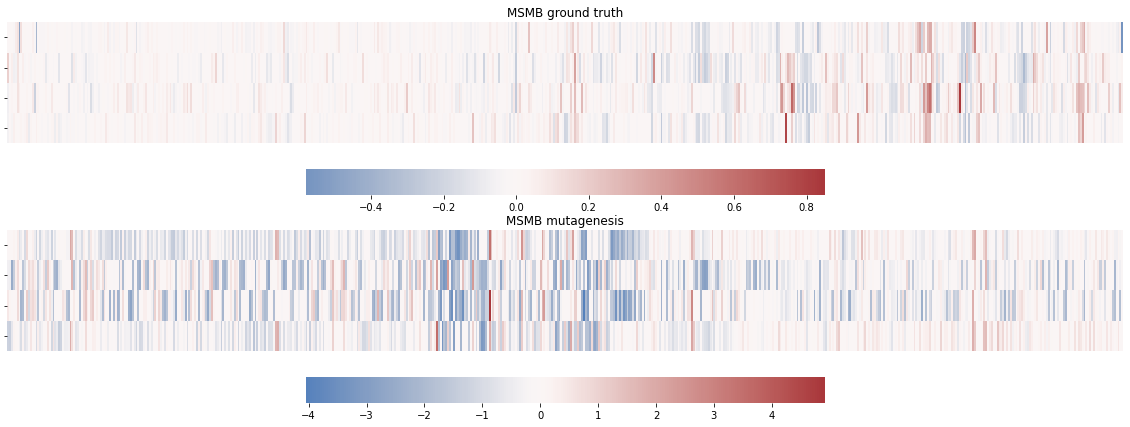

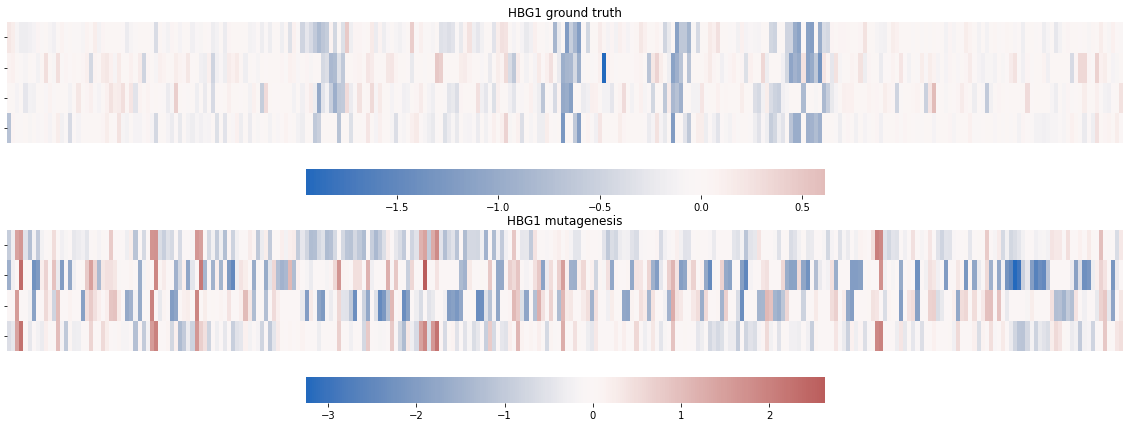

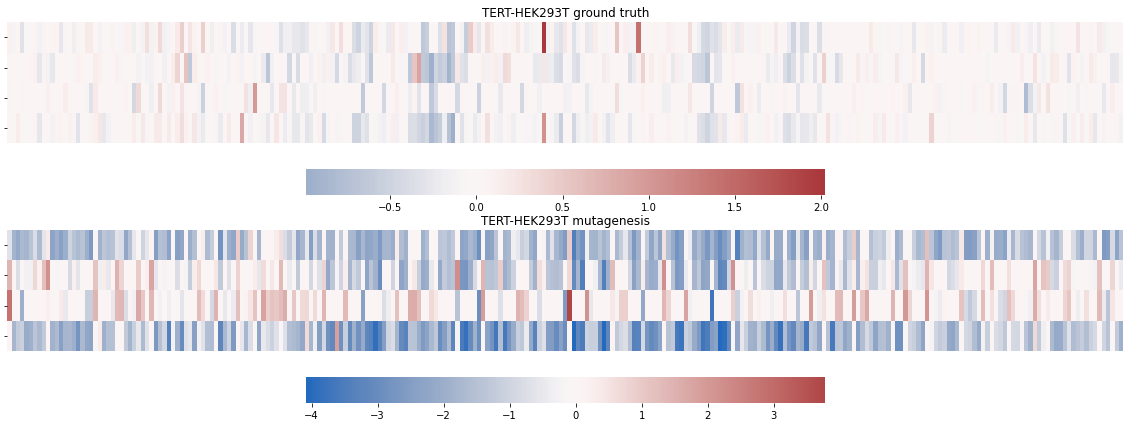

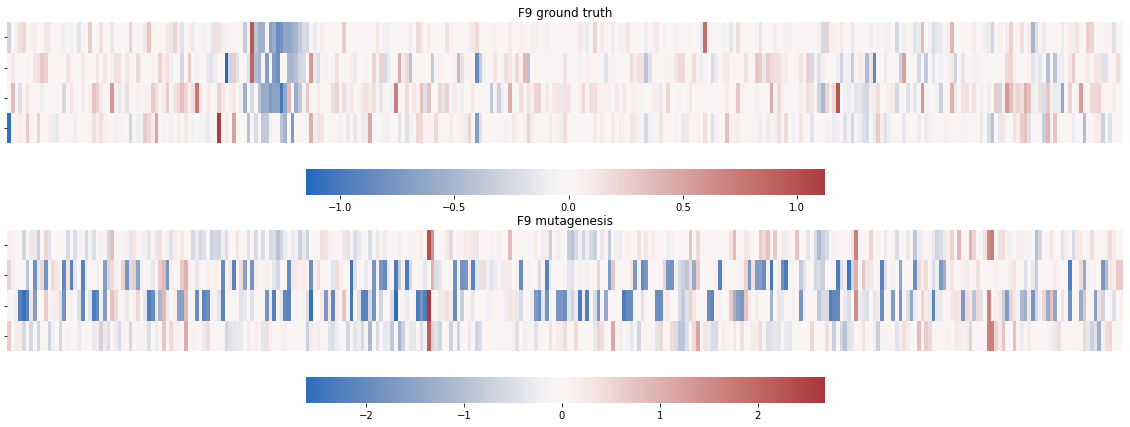

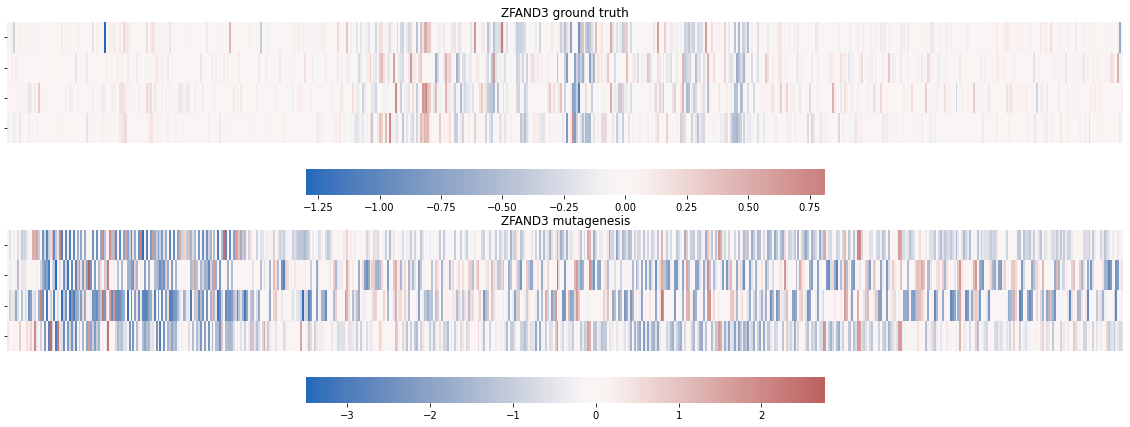

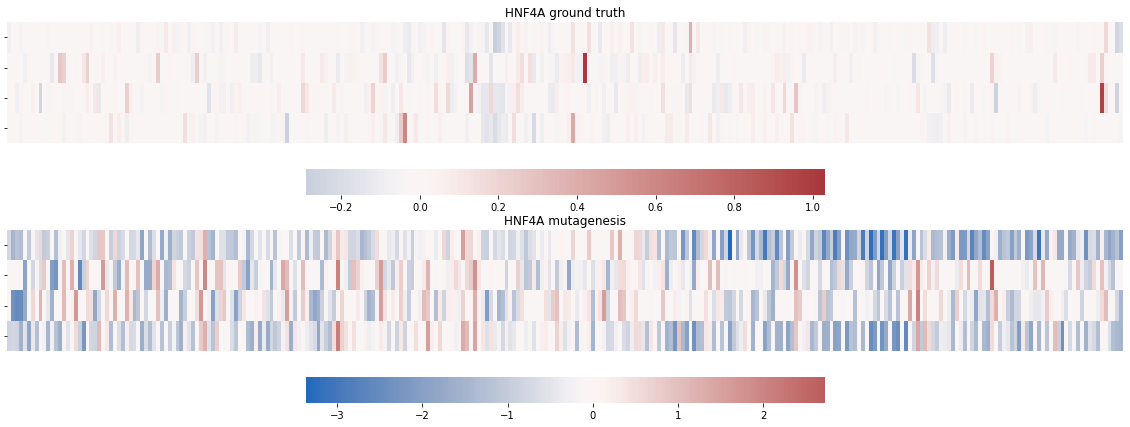

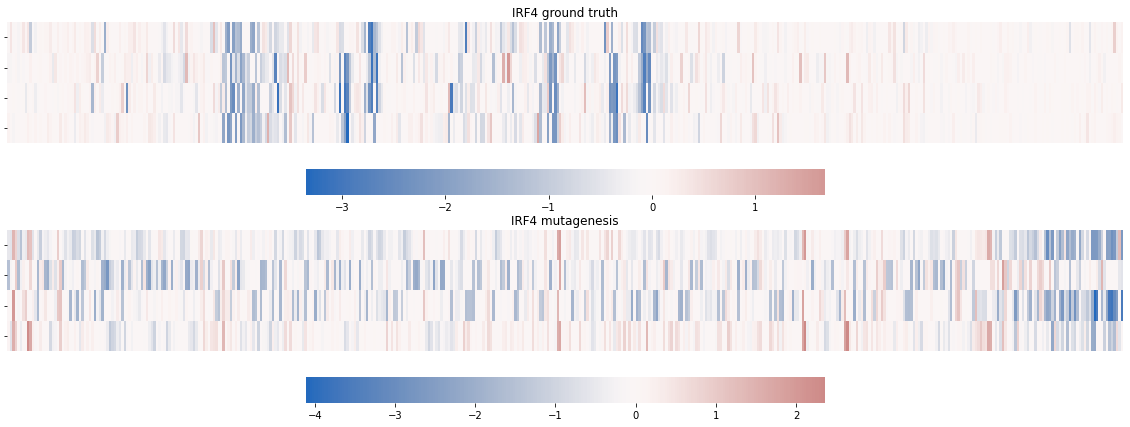

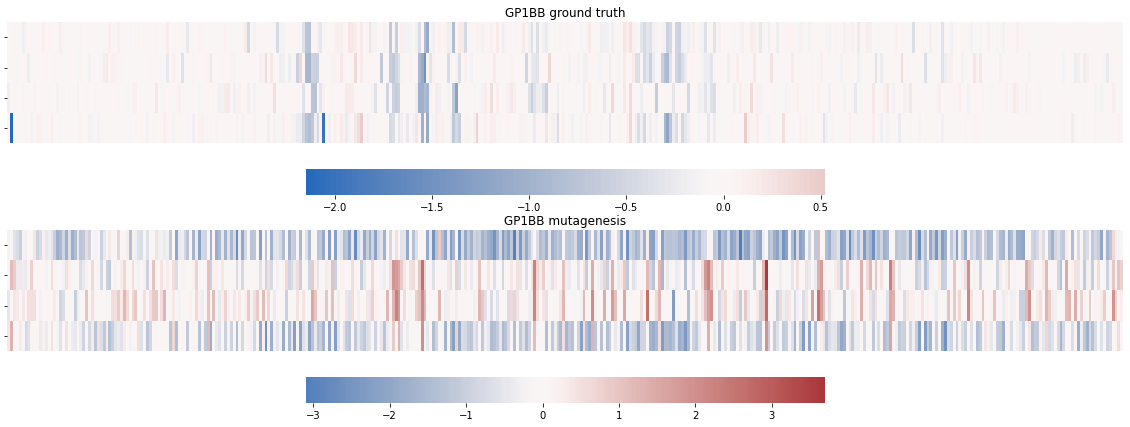

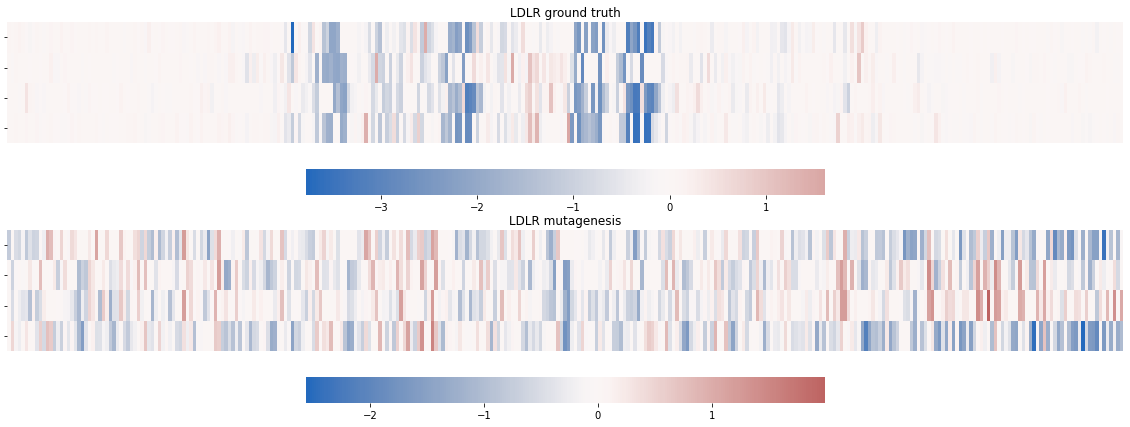

In [27]:
idx = {'A':0,'C':1,'G':2,'T':3}
for exp in exp_list:
    exp_df = cagi_df[cagi_df['8']==exp]
    idx_df = exp_df[['0','1','2']].drop_duplicates().sort_values(by=['1'])
    exp_len = len(exp_df['1'].unique())
    effect_size = np.zeros((4,exp_len))
    predict_size = np.zeros((4,exp_len))
    
    for pos in range(0,exp_len):
        row = idx_df.iloc[pos]
        loci_df = exp_df[(exp_df['0']==row['0'])&(exp_df['1']==row['1'])&(exp_df['2']==row['2'])]
        loci_idx = loci_df.index
        ref_allele = loci_df['3'].drop_duplicates().values
        alt_allele = loci_df['4'].values.tolist()
        diff = loci_df['6'].values

        effect_size[itemgetter(*alt_allele)(idx),pos] =diff
        predict_size [itemgetter(*alt_allele)(idx),pos] =llr[loci_idx]

    fig,ax = plt.subplots(2,1,figsize = (20,7))
    #fig2=plt.figure(figsize = (20,2))
    fig1 = sns.heatmap(effect_size,cmap = 'vlag',
                        center = 0,
                        #annot = exp_annot,fmt = '',
                    cbar_kws = dict(use_gridspec=False,location="bottom"),
                    ax = ax[0]);
    ax[0].tick_params(left=True, bottom=False);
    #ax.set_yticklabels(['A','C','G','T'],size = 1);
    ax[0].set_yticklabels([])
    ax[0].set_xticklabels([]);
    ax[0].set_title(exp+' ground truth')
    #plt.tight_layout()

    #fig3=plt.figure(figsize = (20,2))
    fig2 = sns.heatmap(predict_size,cmap = 'vlag',
                        center = 0,
                        #annot = pred_annot,fmt = '',
                        cbar_kws = dict(use_gridspec=False,location="bottom"),
                        ax = ax[1]);
    ax[1].tick_params(left=True, bottom=False);
    #ax.set_yticklabels(['A','C','G','T'],size = 1);
    ax[1].set_yticklabels([])
    ax[1].set_xticklabels([])
    ax[1].set_title(exp+' mutagenesis')